# Chemical Reactions Type Prediction
In this notebook, I will be going to investigate the prediction of reaction types based on the USPTO-15K dataset for chemical reactions.


## Checking GPU Type

In [1]:
import numpy as np
import os
import random
import torch
model_path = os.path.join("model_weights", "reaction_classifier")
data_path = "Liu_Kheyer_Retrosynthesis_Data"

In [ ]:
SEED = 42
# fix seeds
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## Data Extraction and Exploration
We will be using the data processed by Liu et Al:
<br>
We need first to preprocess the existing data into a suitable format for our model:
1. Load the data into Pandas dataframes
2. Seperate the reaction type from the reactants data
3. Load the reactants, products, reaction types into the same dataframe


In [ ]:
train_path = os.path.join(data_path, "train")
validation_path = os.path.join(data_path, "validation")
test_path = os.path.join(data_path, "test")

In [ ]:
import pandas as pd
train_reactants_df = pd.read_csv(os.path.join(
    train_path, "train_targets.txt"), header=None)
train_products_df = pd.read_csv(os.path.join(
    train_path, "train_sources.txt"), header=None)

In [ ]:
def process_dfs(react_df, prod_df):
    react_df_n = react_df.copy()
    prod_df_n = prod_df.copy()
    prod_df_n.rename(columns={0: "products"}, inplace=True)
    react_df_n.rename(columns={0: "reactants"}, inplace=True)
    prod_df_n["reaction_type"] = prod_df_n["products"].str.extract(
        r"(\<RX_.*\>)")
    prod_df_n["products"] = prod_df_n["products"].str.replace(
        r"(\<RX_.*\>)", "")
    df = pd.concat([react_df_n, prod_df_n], axis=1)
    return df


def prepare_whole_reaction_padded(df):
    df["full_input_format"] = df["reactants"].str.replace(
        " ", "")+">>"+df["products"].str.replace(" ", "")


df = process_dfs(train_reactants_df, train_products_df)
prepare_whole_reaction_padded(df)
df[df["products"] ==
    df["products"].value_counts()
    .index[0]]

In [ ]:
df[df["reactants"] ==
    df["reactants"].value_counts()
    .index[0]]

,reactants,products,reaction_type
1305,C C ( C ) ( C ) O C ( = O ) N C C ( = O ) N 1 ...,O = C ( O ) C ( F ) ( F ) F,<RX_6>
14204,C C ( C ) ( C ) O C ( = O ) N C C ( = O ) N 1 ...,N = C ( N ) N C C C [ C @ H ] ( N C ( = O ) [...,<RX_6>
38911,C C ( C ) ( C ) O C ( = O ) N C C ( = O ) N 1 ...,C c 1 c c c ( S ( = O ) ( = O ) O ) c c 1,<RX_6>


In [ ]:
df.loc[0, "full_input_format"]

'CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)cc1Cl>>O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1'

## Preprocessing Reaction Fingerprints

In [ ]:
def delete_outliers(df, max_value):
    to_del = df[df["full_input_format"].str.len().sort_values(
        ascending=False) > max_value].index
    df1 = df.drop(to_del)
    print(to_del.shape)
    return df1


df1 = delete_outliers(df, 400)
(df1["full_input_format"].str.len().sort_values(ascending=False) > 400).sum()

(0,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


0

In [ ]:
from rdkit.Chem import rdChemReactions
from rdkit.Chem import DataStructs


def create_fingerprints(df, params):
    df["rxn"] = df["full_input_format"].apply(
        lambda x: rdChemReactions.ReactionFromSmarts(x, useSmiles=True))
    df["fingerprint"] = df["rxn"].apply(
        lambda x: rdChemReactions.CreateDifferenceFingerprintForReaction(x, params))
    fingerprints = []
    fps = []
    for i in df.index:
        array = np.zeros((0, ), dtype=np.int64)
        DataStructs.ConvertToNumpyArray(df.loc[i, "fingerprint"], array)
        fingerprints.append(array)
        fps.append(df.loc[i, "fingerprint"])

    return np.stack(fingerprints), fps


params = rdChemReactions.ReactionFingerprintParams()
params.fpSize = 2048
train_inputs, train_fps = create_fingerprints(df1, params)
len(train_inputs[0])

2048

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()


def tokenize_reaction_type(df):
    le.fit(df["reaction_type"])
    return le.transform(df["reaction_type"])


train_outputs = tokenize_reaction_type(df1)
print(le.classes_)

In [ ]:
weights = 1/df1["reaction_type"].value_counts().sort_index()

reactions = le.classes_
class_weights = {}
for el in reactions:
    class_weights[le.transform([el])[0]] = weights[el]
class_weights, weights

<RX_10>    0.005525
<RX_1>     0.000083
<RX_2>     0.000105
<RX_3>     0.000222
<RX_4>     0.001389
<RX_5>     0.001923
<RX_6>     0.000150
<RX_7>     0.000273
<RX_8>     0.001536
<RX_9>     0.000682
Name: reaction_type, dtype: float64

## Preparing validation and test data

Now let's create the pipeline for validation and test data:

In [ ]:
def data_to_Ids_pipeline(reactants_df, products_df, max_to_del=0):
    dfa = process_dfs(reactants_df, products_df)
    prepare_whole_reaction_padded(dfa)
    dfa = delete_outliers(dfa, max_to_del)
    inputs, fps = create_fingerprints(dfa, params)
    outputs = tokenize_reaction_type(dfa)
    return dfa, inputs, outputs


valid_df, valid_inputs, valid_outputs = data_to_Ids_pipeline(
    valid_reactants_df, valid_products_df, max_to_del=400)

test_df, test_inputs, test_outputs = data_to_Ids_pipeline(
    test_reactants_df, test_products_df, max_to_del=400)

Now let's tokenize the validation text and test text:

In [ ]:
valid_products_df = pd.read_csv(os.path.join(
    validation_path, "valid_sources.txt"), header=None)
valid_reactants_df = pd.read_csv(os.path.join(
    validation_path, "valid_targets.txt"), header=None)

test_products_df = pd.read_csv(os.path.join(
    test_path, "test_sources.txt"), header=None)
test_reactants_df = pd.read_csv(os.path.join(
    test_path, "test_targets.txt"), header=None)

In [ ]:
print("Shape of validation Ids inputs:", valid_inputs.shape)
print("Shape of validation Ids output:", valid_outputs.shape)
print("Shape of Test Ids inputs:",  test_inputs.shape)
print("Shape of Test Ids output:",  test_outputs.shape)

Shape of validation Ids inputs: (5004, 2048)
Shape of validation Ids output: (5004,)


In [ ]:
train_inputs_ml = np.concatenate([train_inputs, valid_inputs])
print(train_inputs_ml.shape)
train_outputs_ml = np.concatenate([train_outputs, valid_outputs])
print(train_outputs_ml.shape)

(45033, 2048)
(45033,)


In [ ]:
class_weights_ml = {}
counts = np.unique(train_outputs_ml, return_counts=True)
for key in counts[0]:
    class_weights_ml[key] = 1/counts[1][key]

class_weights_ml

{0: 0.004901960784313725,
 1: 7.347538574577516e-05,
 2: 9.326618168252192e-05,
 3: 0.00019704433497536947,
 4: 0.0012345679012345679,
 5: 0.0017094017094017094,
 6: 0.00013301409949454643,
 7: 0.0002423654871546292,
 8: 0.001364256480218281,
 9: 0.0006060606060606061}

In [ ]:
import pickle
with open(os.path.join(train_path, "train_targets_ids_fingerprints.fps"), "wb") as f:
    pickle.dump(train_fps, f)
with open(os.path.join(train_path, "train_targets_ids_fingerprints.data"), "w") as f:
    np.savetxt(f, train_inputs, newline='\n')
with open(os.path.join(validation_path, "validation_targets_ids_fingerprint.data"), "w") as f:
    np.savetxt(f, valid_inputs, newline='\n')
with open(os.path.join(test_path, "test_targets_ids_fingerprints.data"), "w") as f:
    np.savetxt(f, test_inputs, newline='\n')

## Training

### Training a Random Forest Classifier

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

rndforest_model = RandomForestClassifier(
    class_weight=class_weights_ml, n_estimators=200, criterion='gini', max_depth=25, n_jobs=-1)
rndforest_model.fit(train_inputs_ml, train_outputs_ml)

y_train_pred = rndforest_model.predict(train_inputs_ml)
train_score = accuracy_score(train_outputs_ml, y_train_pred)
y_val_pred = rndforest_model.predict(test_inputs)
val_score = accuracy_score(test_outputs, y_val_pred)

print(classification_report(test_outputs, y_val_pred))
train_score, val_score

              precision    recall  f1-score   support

           0       1.00      0.83      0.90        23
           1       0.97      0.96      0.96      1512
           2       0.99      0.97      0.98      1191
           3       0.99      0.91      0.95       564
           4       0.98      0.89      0.93        90
           5       0.98      0.98      0.98        65
           6       0.96      0.98      0.97       835
           7       0.93      0.97      0.95       459
           8       1.00      0.98      0.99        81
           9       0.72      0.96      0.82       184

    accuracy                           0.96      5004
   macro avg       0.95      0.94      0.94      5004
weighted avg       0.96      0.96      0.96      5004



In [ ]:
import pickle
filename = os.path.join(model_path, 'rndforest_classifier.reg')
pickle.dump(rndforest_model, open(filename, 'wb'))

### Training a Neural Network

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

device(type='cuda', index=0)

In [ ]:
BATCH_SIZE = 256

# transform to torch tensor
train_tensor_x = torch.Tensor(train_inputs).float().cuda()
train_tensor_y = torch.Tensor(train_outputs).long().cuda()

# create train dataset
train_dataset = TensorDataset(train_tensor_x, train_tensor_y)
# create train dataloader
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# transform to torch tensor
valid_tensor_x = torch.Tensor(valid_inputs).float().cuda()
valid_tensor_y = torch.Tensor(valid_outputs).long().cuda()

# create valid dataset
valid_dataset = TensorDataset(valid_tensor_x, valid_tensor_y)
# create valid dataloader
valid_dataloader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# transform to torch tensor
test_tensor_x = torch.Tensor(test_inputs).float().cuda()
test_tensor_y = torch.Tensor(test_outputs).long().cuda()

# create test dataset
test_dataset = TensorDataset(test_tensor_x, test_tensor_y)
# create test dataloader
test_dataloader = DataLoader(test_dataset)

In [ ]:
model = nn.Sequential(nn.Linear(2048, 32),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(32, 10)).cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(model)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss(weight=torch.tensor(
    list(class_weights.values())).float().cuda())
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    y_pred_tags = torch.argmax(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()

    acc = correct_pred.sum()

    return acc

In [ ]:
import tqdm
NUM_EPOCHS = 50

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# training
for i in tqdm.notebook.tqdm(range(NUM_EPOCHS), desc='training'):
    train_loss_sum = 0
    train_correct = 0
    for train_element in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(train_element[0])
        train_correct += multi_acc(outputs, train_element[1])
        loss = criterion(outputs, train_element[1])
        loss.backward()
        train_loss_sum += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        optimizer.zero_grad()
    train_loss_sum = train_loss_sum/train_inputs.shape[0]
    train_correct = train_correct/train_inputs.shape[0]
    train_loss.append(train_loss_sum)
    train_accuracy.append(train_correct)
    print(f'training loss at epoch {i}: {train_loss_sum:.5f}')
    print(f'training accuracy at epoch {i}: {train_correct:.5f}')

    with torch.no_grad():
        model.eval()
        val_loss_sum = 0
        val_correct = 0
        for val_element in valid_dataloader:
            outputs = model(val_element[0])
            val_correct += multi_acc(outputs, val_element[1])
            loss = criterion(outputs, val_element[1])
            val_loss_sum += loss.item()

        val_loss_sum = val_loss_sum/valid_inputs.shape[0]
        val_correct = val_correct/valid_inputs.shape[0]
        val_loss.append(val_loss_sum)
        val_accuracy.append(val_correct)
        print(f'validation loss at epoch {i}: {val_loss_sum:.5f}')
        print(f'validation accuracy at epoch {i}: {val_correct:.5f}')
        print("--------------------------------------------------------- \n")

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, os.path.join(model_path, "rxn_type_model"+str(i)+".pth"))

    with open(os.path.join(model_path, "rxn_type_val_loss.pkl"), 'wb') as f:
        pickle.dump(val_loss, f)
    with open(os.path.join(model_path, "rxn_type_train_loss.pkl"), 'wb') as f:
        pickle.dump(train_loss, f)
    with open(os.path.join(model_path, "rxn_type_val_accuracy.pkl"), 'wb') as f:
        pickle.dump(val_accuracy, f)
    with open(os.path.join(model_path, "rxn_type_train_accuracy.pkl"), 'wb') as f:
        pickle.dump(train_accuracy, f)

train loss:


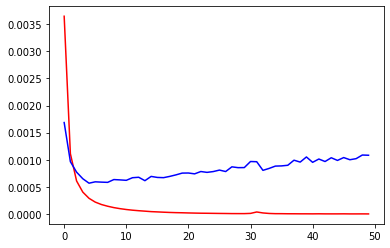

train accuracy:


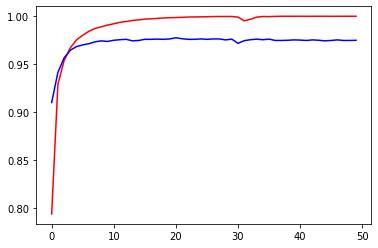

In [ ]:
import matplotlib.pyplot as plt

print("train loss:")
plt.plot(train_loss, 'r')
plt.plot(val_loss, 'b')
plt.show()

print("train accuracy:")
plt.plot(train_accuracy, 'r')
plt.plot(val_accuracy, 'b')
plt.show()

In [ ]:
np.argmin(val_loss)

4

In [ ]:
tools["model"].eval()
test_pred = []
for test_element in test_dataloader:
    outputs = tools["model"](test_element[0])
    y_pred_softmax = torch.log_softmax(outputs, dim=1)
    y_pred_tags = torch.argmax(y_pred_softmax, dim=1)
    for x in y_pred_tags:
        test_pred.append(x.item())

# (test_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_outputs, test_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        23
           1       0.98      0.97      0.98      1512
           2       0.98      0.97      0.98      1191
           3       0.97      0.97      0.97       564
           4       0.94      0.97      0.95        90
           5       0.97      0.97      0.97        65
           6       0.97      0.99      0.98       835
           7       0.96      0.98      0.97       459
           8       0.96      1.00      0.98        81
           9       0.97      0.94      0.95       184

    accuracy                           0.97      5004
   macro avg       0.96      0.97      0.96      5004
weighted avg       0.97      0.97      0.97      5004



In [ ]:
torch.save(model, os.path.join(model_path, "final_nn_classifier.pth"))